In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def planck_function(lambda_wavelength, T):
    h = 6.62607015e-34      # Planck's constant, J*s
    c = 2.998e8             # Speed of light, m/s
    kB = 1.380649e-23       # Boltzmann's constant, J/K
    term1 = (2 * h * c**2) / lambda_wavelength**5
    term2 = np.exp((h * c) / (lambda_wavelength * kB * T)) - 1
    return term1 / term2

In [4]:
def pressure(z):
    P0 = 101325     # Pressure at sea level in Pa
    H = 8500        # Scale height in m
    return P0 * np.exp(-z / H)

def temperature_uniform(z):
    T0 = 288.2
    return T0 * np.ones_like(z)

def temperature_simple(z):
    T0 = 288.2     # Temperature at sea level in K
    z_trop = 11000  # Tropopause height in m
    Gamma = -0.0065 # Temperature gradient in K/m
    T_trop = T0 + Gamma * z_trop
    return np.piecewise(z, [z < z_trop, z >= z_trop],
                        [lambda z: T0 + Gamma * z,
                         lambda z: T_trop])

def temperature_US1976(z):
    z_km = z/1000  # Convert altitude to km for easier comparisons

    # Troposphere (0 to 11 km)
    T0 = 288.15
    z_trop = 11

    # Tropopause (11 to 20 km)
    T_tropopause = 216.65
    z_tropopause = 20

    # Stratosphere 1 (20 to 32 km)
    T_strat1 = T_tropopause
    z_strat1 = 32

    # Stratosphere 2 (32 to 47 km)
    T_strat2 = 228.65
    z_strat2 = 47

    # Stratopause (47 to 51 km)
    T_stratopause = 270.65
    z_stratopause = 51

    # Mesosphere 1 (51 to 71 km)
    T_meso1 = T_stratopause
    z_meso1 = 71

    # Mesosphere 2 (71 to ...)
    T_meso2 = 214.65

    return np.piecewise(z_km,
                        [z_km < z_trop,
                         (z_km >= z_trop) & (z_km < z_tropopause),
                         (z_km >= z_tropopause) & (z_km < z_strat1),
                         (z_km >= z_strat1) & (z_km < z_strat2),
                         (z_km >= z_strat2) & (z_km < z_stratopause),
                         (z_km >= z_stratopause) & (z_km < z_meso1),
                         z_km >= z_meso1],
                        [lambda z: T0 - 6.5 * z,
                         lambda z: T_tropopause,
                         lambda z: T_strat1 + 1 * (z - z_tropopause),
                         lambda z: T_strat2 + 2.8 * (z - z_strat1),
                         lambda z: T_stratopause,
                         lambda z: T_meso1 - 2.8 * (z - z_stratopause),
                         lambda z: T_meso2 - 2 * (z - z_meso1)])

In [5]:
def temperature(z):
    return temperature_simple(z)

def air_number_density(z):
    kB = 1.380649e-23  # Boltzmann's constant, J/K
    return pressure(z) / (kB * temperature(z))

In [6]:
def cross_section_CO2(wavelength):
    LAMBDA_0 = 15.0e-6  # Band center in m
    exponent = -22.5 - 24 * np.abs((wavelength - LAMBDA_0) / LAMBDA_0)
    sigma = 10 ** exponent
    return sigma

In [7]:
def simulate_radiative_transfer(CO2_fraction, z_max = 80000, delta_z = 10, lambda_min = 0.1e-6, lambda_max = 100e-6, delta_lambda = 0.01e-6):

    # Altitude and wavelength grids
    z_range = np.arange(0, z_max, delta_z)
    lambda_range = np.arange(lambda_min, lambda_max, delta_lambda)

    # Initialize arrays
    upward_flux = np.zeros((len(z_range), len(lambda_range)))
    optical_thickness = np.zeros((len(z_range), len(lambda_range)))

    # Boundary condition : Compute the outward vertical flux emitted by the Earth's surface for all wavelengths
    earth_flux = np.pi * planck_function(lambda_range, temperature(0)) * delta_lambda
    print(f"Total earth surface flux in wavelength range: {earth_flux.sum():.2f} W/m^2")

    flux_in = earth_flux
    for i, z in enumerate(z_range):

        # Number density of CO2 molecules and absorption coefficient
        n_CO2 = air_number_density(z) * CO2_fraction
        kappa = cross_section_CO2(lambda_range) * n_CO2

        # Compute fluxes within the layer
        optical_thickness[i,:] = kappa * delta_z
        absorbed_flux = np.minimum(kappa * delta_z * flux_in , flux_in)
        emitted_flux = optical_thickness[i,:] * np.pi * planck_function(lambda_range, temperature(z)) * delta_lambda
        upward_flux[i, :] = flux_in - absorbed_flux + emitted_flux

        # The flux leaving the layer becomes the flux entering the next layer
        flux_in = upward_flux[i, :]

    print(f"Total outgoing flux at the top of the atmosphere: {upward_flux[-1,:].sum():.2f} W/m^2")

    return lambda_range, z_range, upward_flux, optical_thickness

Total earth surface flux in wavelength range: 388.03 W/m^2
Total outgoing flux at the top of the atmosphere: 335.03 W/m^2
Total earth surface flux in wavelength range: 388.03 W/m^2
Total outgoing flux at the top of the atmosphere: 330.22 W/m^2


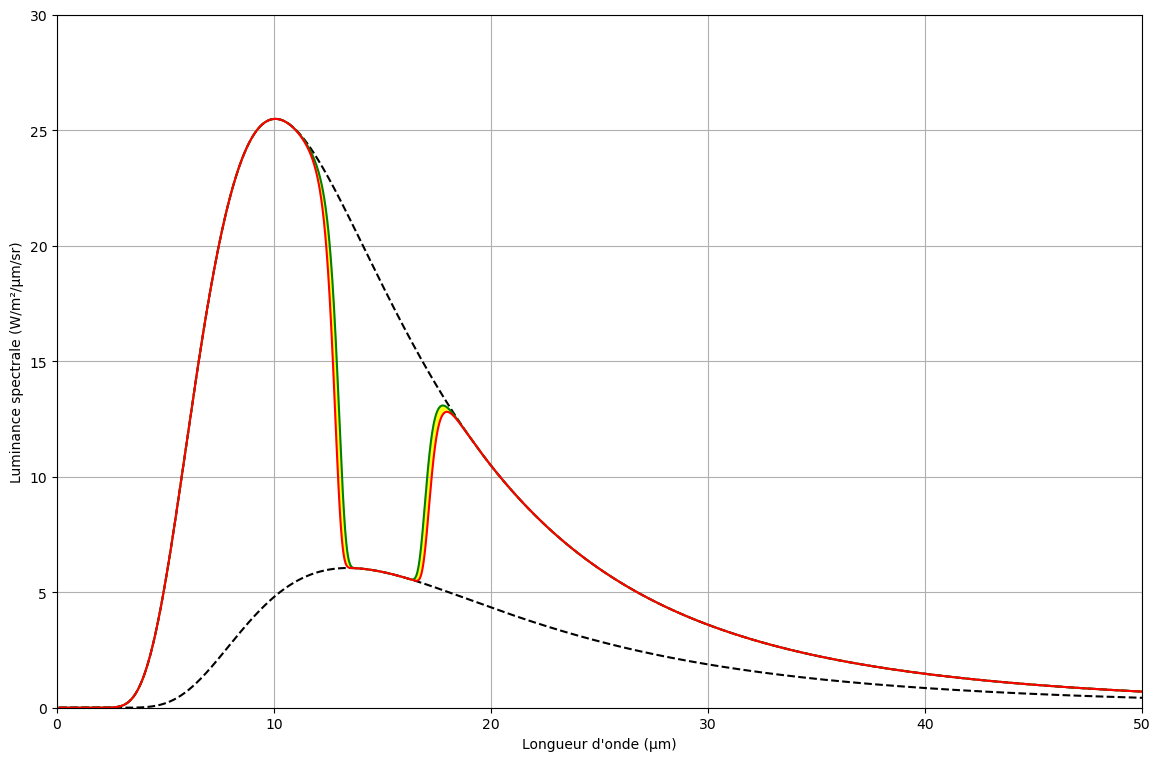

In [8]:
CO2_fraction = 280e-6
lambda_range, z_range, upward_flux, optical_thickness = simulate_radiative_transfer(CO2_fraction)
CO2_fraction *= 2
lambda_range, z_range, upward_flux2, optical_thickness2 = simulate_radiative_transfer(CO2_fraction)

# Plot top of atmosphere spectrum
plt.figure(figsize=(14, 9))
# Superimpose blackbody spectrum at Earth's surface temperature and 220K
plt.plot(1e6 * lambda_range, np.pi * planck_function(lambda_range, temperature(0))/1e6,'--k')
plt.plot(1e6 * lambda_range, np.pi * planck_function(lambda_range, 216)/1e6,'--k')

delta_lambda = lambda_range[1] - lambda_range[0]
plt.plot(1e6 * lambda_range, upward_flux[-1, :]/delta_lambda/1e6,'-g')
plt.plot(1e6 * lambda_range, upward_flux2[-1, :]/delta_lambda/1e6,'-r')
plt.fill_between(1e6 * lambda_range, upward_flux[-1, :]/delta_lambda/1e6, upward_flux2[-1, :]/delta_lambda/1e6, color='yellow', alpha=0.9)
plt.xlabel("Longueur d'onde (μm)")
plt.ylabel("Luminance spectrale (W/m²/μm/sr)")
plt.xlim(0, 50)
plt.ylim(0, 30)
plt.grid(True)
plt.show()